# Imports & Load Data

In [1]:
import numpy as np
import os
import glob
import shutil
import cv2
import matplotlib.pyplot as plt
import random
from typing import List, Tuple

In [2]:
from google.colab import userdata

os.environ['WANDB_DISABLED'] = 'true'
roboflow_api = userdata.get('ROBOFLOW')

In [3]:
!pip install -q ultralytics roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.7/863.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 12.7 MB/s eta 0:00:00


In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key=roboflow_api)
project = rf.workspace("brad-dwyer").project("pothole-voxrl")
version = project.version(1)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pothole-1 in yolov9:: 100%|██████████| 1342/1342 [00:00<00:00, 2751.45it/s]


In [5]:
DATA_PATH = '/content/Pothole-1'
YAML_PATH = os.path.join(DATA_PATH, 'data.yaml')
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH =  os.path.join(DATA_PATH, 'test')
VAL_PATH =   os.path.join(DATA_PATH, 'valid')

### Visualizing Dataset

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [7]:
def yolo2bbox(bboxes: List[float])->tuple[float]:
  """
  Convert bounding boxes from YOLO format to standard bounding box format.

  Args:
      bboxes (tuple or list of float): A tuple or list containing four elements representing the bounding box in YOLO format.
          - bboxes[0] (float): The x-coordinate of the center of the bounding box (normalized).
          - bboxes[1] (float): The y-coordinate of the center of the bounding box (normalized).
          - bboxes[2] (float): The width of the bounding box (normalized).
          - bboxes[3] (float): The height of the bounding box (normalized).

  Returns:
      tuple of float: A tuple representing the bounding box in standard format (xmin, ymin, xmax, ymax).
          - xmin (float): The x-coordinate of the bottom-left corner of the bounding box.
          - ymin (float): The y-coordinate of the bottom-left corner of the bounding box.
          - xmax (float): The x-coordinate of the top-right corner of the bounding box.
          - ymax (float): The y-coordinate of the top-right corner of the bounding box.
  """
  xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
  xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
  return xmin, ymin, xmax, ymax

def plot_bboxes(img: np.ndarray, bboxes: List[List[float]], labels: List[bool]=None)->np.ndarray:
  """
  Plot bounding boxes on an image with optional labels.

  Args:
      img (numpy.ndarray): The image on which to draw the bounding boxes.
          Should be a NumPy array with shape (H, W, C), where H is the height, W is the width, and C is the number of color channels (usually 3 for RGB).
      bboxes (list of tuples or lists of float): A list containing bounding boxes in YOLO format.
          Each bounding box is represented by a tuple or list with four elements:
          - x_center (float): The x-coordinate of the center of the bounding box (normalized).
          - y_center (float): The y-coordinate of the center of the bounding box (normalized).
          - width (float): The width of the bounding box (normalized).
          - height (float): The height of the bounding box (normalized).
      labels (list of int, optional): A list of labels corresponding to each bounding box. If provided, the label is used to determine the color of the bounding box.
          - 0 (int): Will be drawn in yellow.
          - 1 (int): Will be drawn in magenta.
          If None, default colors will be used.

  Returns:
      numpy.ndarray: The image with bounding boxes drawn on it. The image is returned in the same format as the input.
  """
  h, w, _ = img.shape
  if len(set(labels))<3:
    colors= [(i, j, k) for i in (0, 255) for j in (0, 255) for k in (0, 255) if not(i==j and j==k)]
  for box_num, box in enumerate(bboxes):
    x1, y1, x2, y2 = yolo2bbox(box)
    #Denormalizing the coordinates
    xmin = int(x1*w)
    ymin = int(y1*h)
    xmax = int(x2*w)
    ymax = int(y2*h)

    thickness = max(2, int(w/275))
    if len(set(labels))<3:
      color = colors[box_num%len(colors)]
    elif labels[box_num] == 0:
      color = (255, 255, 0)
    else:
      color = (200, 0, 255)
    cv2.rectangle(
        img,
        (xmin, ymin), (xmax, ymax),
        color = color,
        thickness = thickness
    )
  return img

In [8]:
def plot(images_path: str, labels_path: str, cols: int=4, rows: int= 3)->None:
  """
  Display a grid of images with their corresponding bounding boxes and labels.

  Args:
      images_path (str): Path to the directory containing images.
      labels_path (str): Path to the directory containing label files (one per image).
      cols (int, optional): Number of columns in the grid. Default is 4.
      rows (int, optional): Number of rows in the grid. Default is 3.

  Returns:
      None
  """
  all_images = os.listdir(images_path)
  all_images.sort()

  num_images = len(all_images)

  fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(20,20))
  for i in range(cols*rows):
    j = np.random.randint(0, num_images-1)
    image_path = os.path.join(images_path, all_images[j])
    label_path = os.path.join(labels_path, all_images[j][:-4]+'.txt')

    with open(label_path, 'r') as f:
      label_lines = f.readlines()
      annotations = [(list(map(float, annotation.split(' ')))) for annotation in label_lines]
      bboxes = []
      labels = []
      for annotation in annotations:
        labels.append(annotation[0])
        bboxes.append(annotation[1:])

    image = cv2.imread(image_path)
    res_image = plot_bboxes(image, bboxes, labels)
    ax.flatten()[i].imshow(image)

  plt.tight_layout()
  plt.show()

plot(os.path.join(TRAIN_PATH, 'images'), os.path.join(TRAIN_PATH, 'labels'), 3)

Output hidden; open in https://colab.research.google.com to view.

# Train YOLOv9

In [9]:
from ultralytics import YOLO

#load model
model = YOLO('yolov9c.pt')

100%|██████████| 49.4M/49.4M [00:00<00:00, 115MB/s] 


### Specify YAML file

In [10]:
yaml_content = f"""
names:
- pothole
nc: 1
roboflow:
  license: ODbL v1.0
  project: pothole-voxrl
  url: https://universe.roboflow.com/brad-dwyer/pothole-voxrl/dataset/1
  version: 1
  workspace: brad-dwyer
test: {TEST_PATH}
train: {TRAIN_PATH}
val: {VAL_PATH}
"""

with open(YAML_PATH, 'w') as file:
    file.write(yaml_content)

### Training Model

In [11]:
#training_parameters
EPOCHS = 20
BATCH = 8
IMG_SIZE = 640
RESULTS_PATH = 'yolov9_c'

#train
results = model.train(
    data = YAML_PATH,
    imgsz = IMG_SIZE,
    epochs = EPOCHS,
    batch = BATCH,
    name = RESULTS_PATH
)

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/content/Pothole-1/data.yaml, epochs=20, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov9_c, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 755k/755k [00:00<00:00, 24.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 118MB/s]


AMP: checks passed ✅


train: Scanning /content/Pothole-1/train/labels... 465 images, 0 backgrounds, 0 corrupt: 100%|██████████| 465/465 [00:00<00:00, 2083.62it/s]

train: New cache created: /content/Pothole-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/Pothole-1/valid/labels... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<00:00, 1665.58it/s]

val: New cache created: /content/Pothole-1/valid/labels.cache


Plotting labels to runs/detect/yolov9_c/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov9_c
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       6.2G      1.653      2.601      1.706          7        640: 100%|██████████| 59/59 [00:27<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.04it/s]

                   all        133        330     0.0469      0.382     0.0343     0.0145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.99G      1.787      2.112      1.813          1        640: 100%|██████████| 59/59 [00:24<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        133        330     0.0198      0.352     0.0123    0.00454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.96G       1.86      2.125       1.84          2        640: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.26it/s]

                   all        133        330     0.0861      0.106     0.0216    0.00835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.96G      1.862      2.029       1.86          2        640: 100%|██████████| 59/59 [00:24<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all        133        330     0.0794      0.324     0.0495     0.0204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.97G      1.741      1.865      1.737          4        640: 100%|██████████| 59/59 [00:24<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.13it/s]

                   all        133        330      0.548      0.403       0.43      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.98G      1.728       1.78      1.731          5        640: 100%|██████████| 59/59 [00:24<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.14it/s]


                   all        133        330      0.462       0.31      0.313       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.97G      1.641      1.731      1.675          5        640: 100%|██████████| 59/59 [00:24<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]

                   all        133        330      0.555      0.385      0.421      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       5.9G      1.695      1.742      1.715         21        640: 100%|██████████| 59/59 [00:26<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.10it/s]


                   all        133        330      0.429      0.345      0.366      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.96G      1.631      1.663      1.651          3        640: 100%|██████████| 59/59 [00:24<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.10it/s]


                   all        133        330      0.539      0.521      0.547      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.94G       1.56      1.607      1.602          2        640: 100%|██████████| 59/59 [00:24<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all        133        330      0.611      0.515      0.565      0.299


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.97G      1.573      1.691       1.65          3        640: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]

                   all        133        330      0.682      0.397      0.477      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.96G      1.461      1.485      1.579          1        640: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]


                   all        133        330      0.566      0.499      0.548      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.96G      1.455      1.422      1.562          1        640: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.14it/s]

                   all        133        330       0.57        0.6      0.615      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      5.97G      1.449       1.36      1.554          3        640: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]

                   all        133        330      0.626      0.591      0.631      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.96G      1.371      1.338      1.518          1        640: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]

                   all        133        330      0.765      0.513      0.639      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       5.9G      1.365      1.315       1.51          4        640: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.48it/s]

                   all        133        330      0.731      0.576      0.681      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.96G      1.332      1.272      1.474          1        640: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]

                   all        133        330      0.749      0.621       0.71      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      5.93G      1.247      1.163      1.413          1        640: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]

                   all        133        330      0.736      0.643      0.716      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.98G      1.245      1.128      1.413          2        640: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.16it/s]

                   all        133        330      0.749      0.639      0.733      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      5.96G      1.199      1.054      1.366          6        640: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]

                   all        133        330      0.785      0.618      0.729       0.44



20 epochs completed in 0.183 hours.
Optimizer stripped from runs/detect/yolov9_c/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/yolov9_c/weights/best.pt, 51.6MB

Validating runs/detect/yolov9_c/weights/best.pt...
Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25,320,019 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]


                   all        133        330      0.788      0.619      0.729       0.44
Speed: 0.4ms preprocess, 16.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/yolov9_c


# Validation and Benchmark

### Validation Results

In [12]:
def visualize_yolo_runs(res_dir, num_samples=4):
  """
  Display a grid of random images from a directory.

  Args:
      res_dir (str): Directory containing images.
      num_samples (int, optional): Number of images to display. Default is 4.

  Returns:
      None
  """
  plt.figure(figsize=(20, 20))
  image_names = glob.glob(os.path.join(res_dir, '*.jpg'))
  random.shuffle(image_names)
  for i, image_name in enumerate(image_names):
    image = plt.imread(image_name)
    plt.subplot(2, 2, i+1)
    plt.imshow(image)
    plt.axis("off")
    if i==num_samples-1:
      break
  plt.tight_layout()
  plt.show()

def visualize_yolo_metrics(res_dir: str)->None:
  """
  Display YOLO metrics from PNG files in the runs directory.

  Args:
      res_dir (str): Directory containing the metric images.

  Returns:
      None
  """
  metrics = ['F1_curve', 'PR_curve', 'P_curve', 'R_curve']
  fig, ax = plt.subplots(ncols=2, nrows=(len(metrics)+1)//2, figsize=(10, 8))
  for i, metric in enumerate(metrics):
    try:
      img_path = os.path.join(res_dir, metric+'.png')
      img = cv2.imread(img_path)
      ax.flatten()[i].imshow(img)
      ax.flatten()[i].axis('off')
    except:
      print(f'Error displaying f{metric}')
  plt.tight_layout()
  plt.show()

visualize_yolo_runs(os.path.join('/content/runs/detect', RESULTS_PATH))

Output hidden; open in https://colab.research.google.com to view.

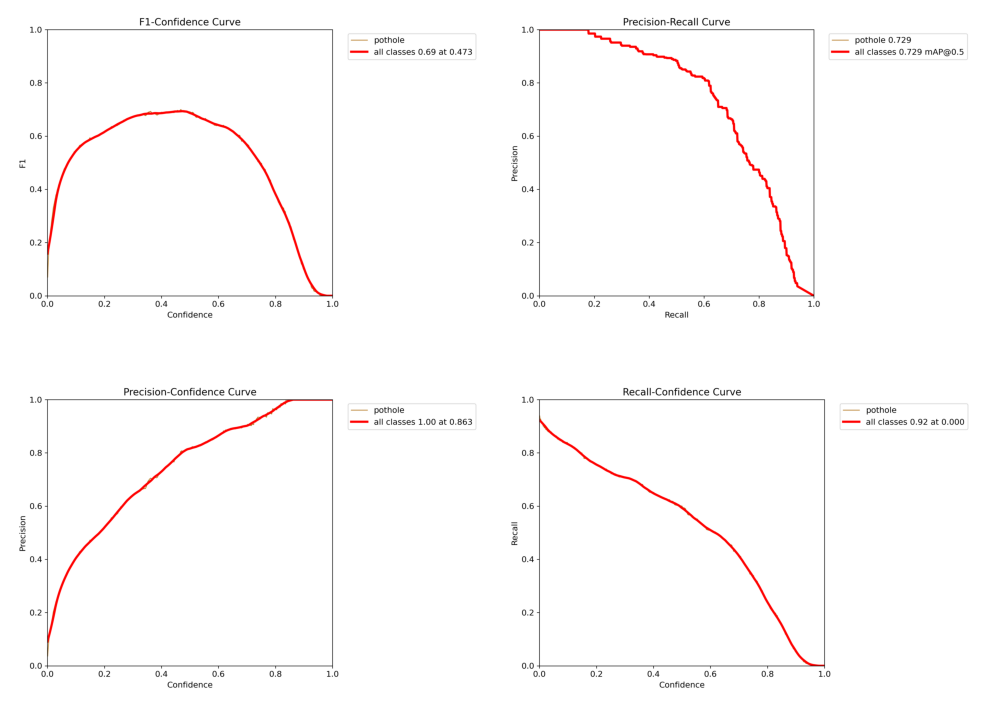

In [13]:
visualize_yolo_metrics(os.path.join('/content/runs/detect', RESULTS_PATH))

### Inference Pipeline

In [14]:
def visualize_inference_pipeline(path: str=None, img=None, verbose=True):
  """
  Visualize the results of an inference pipeline by displaying bounding boxes on an image.

  Args:
      path (str, optional): Path to the image file. If provided, the image will be loaded from this path.
      img (numpy.ndarray, optional): Image array. If provided, this image will be used directly.
      verbose (bool, optional): Whether to print verbose output during inference. Default is True.

  Returns:
      None: Displays the image with bounding boxes drawn on it.
  """
  if path is None and img is None:
    assert ValueError("Either img_path or img must be provided")
    return None
  if img is None:
    outputs = model(path, verbose=verbose)[0]
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  else:
    outputs = model(img, verbose=verbose)[0]
  res = plot_bboxes(img, [box[0].xywhn.tolist()[0] for box in outputs.boxes], outputs.boxes.cls)
  return img

### Inference on real images


image 1/1 /content/pothole.jpg: 448x640 1 pothole, 166.5ms
Speed: 3.0ms preprocess, 166.5ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


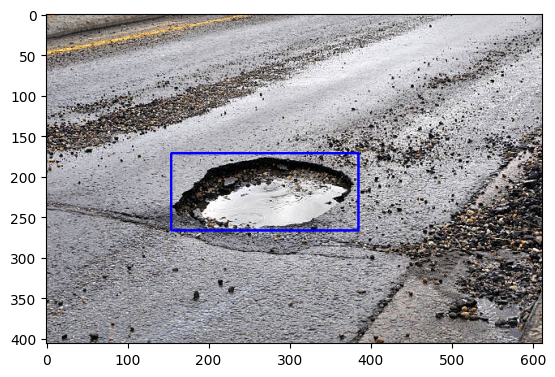

In [15]:
op_img = visualize_inference_pipeline("pothole.jpg")
plt.imshow(op_img)

### Benchmark on Val Set

In [16]:
metrics = model.val()

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/Pothole-1/valid/labels.cache... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.65it/s]


                   all        133        330      0.781      0.627      0.731      0.442
Speed: 0.2ms preprocess, 42.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/yolov9_c2


In [17]:
metrics.results_dict

{'metrics/precision(B)': 0.7814241577434471,
 'metrics/recall(B)': 0.6272727272727273,
 'metrics/mAP50(B)': 0.730530188411161,
 'metrics/mAP50-95(B)': 0.44192749616067173,
 'fitness': 0.47078776538572065}

### Benchmark on Test set

In [18]:
yaml_content = f"""
names:
- pothole
nc: 1
roboflow:
  license: ODbL v1.0
  project: pothole-voxrl
  url: https://universe.roboflow.com/brad-dwyer/pothole-voxrl/dataset/1
  version: 1
  workspace: brad-dwyer
test: {TEST_PATH}
train: {TRAIN_PATH}
val: {TEST_PATH}
"""
with open(YAML_PATH, 'w') as file:
    file.write(yaml_content)

In [19]:
metrics = model.val(data=YAML_PATH)

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/Pothole-1/test/labels... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<00:00, 2040.70it/s]

val: New cache created: /content/Pothole-1/test/labels.cache



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]


                   all         67        154       0.75      0.644      0.729      0.445
Speed: 0.2ms preprocess, 33.7ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/yolov9_c3


In [20]:
metrics.results_dict

{'metrics/precision(B)': 0.7502787870104687,
 'metrics/recall(B)': 0.6438202252569439,
 'metrics/mAP50(B)': 0.7294982518872573,
 'metrics/mAP50-95(B)': 0.44521817629406446,
 'fitness': 0.47364618385338375}